### Train schedules data from Digitraffic

Data from Digitraffic's [https://rata.digitraffic.fi](https://rata.digitraffic.fi)-interface. License [CC 4.0 BY](http://creativecommons.org/licenses/by/4.0/)


### Weather data from the Finnish Meteorological Insititute
https://en.ilmatieteenlaitos.fi/open-data (MIT license)

---



## Predicting the schedule, multi-layer perceptron

### Select training data, from winter 2016-2017

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler

# --------------- TRAINING DATA ----------------- 
training = pd.DataFrame(pd.read_csv('data/JY-HKI-dec16-mar17.csv'))

# Get only long-distance trains
training = training.loc[(training['Category'] == 'Long-distance')  & (training['Train ID'] < 10000) ]

# Drop the columns we don't need, and leave the most correlating
training.drop(training.columns[[0,1,2,3,4,6,7,8,10,11]], axis=1, inplace=True)
#training = training.reset_index(drop=True)

# Save the column names, we need them after scaling
colnames = training.columns

# train the normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(training)

# Scale dataframe and place column names
training2 = pd.DataFrame(scaler.transform(training), columns=colnames)
training2.head()

,Delay,Delay at Dep.,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,-0.899698,-0.981717,0.461255,-1.0,-1.0,-1.0,0.086093,-1.0,-1.0,-0.939394
1,-0.967609,-0.981209,0.461255,-1.0,-1.0,-1.0,0.629139,-1.0,-1.0,-0.878788
2,-0.933207,-0.964195,0.461255,-1.0,-1.0,-1.0,0.509934,-1.0,-1.0,-0.878788
3,-0.897911,-0.982732,0.461255,-1.0,-1.0,-1.0,0.304636,-1.0,-1.0,-0.939394
4,-0.926282,-0.988065,0.453875,-1.0,-1.0,-1.0,0.066225,-1.0,-1.0,-0.939394


### Select target and training columns for MLP

In [2]:
# ----------------- TARGET ----------------
y = training2.iloc[:,0]                            #y = (y - y.mean())/y.std()  # z-score normalization

# Set training columns = all but 'Delay'
X = training2.loc[:, training2.columns != 'Delay'] #or:   X = training2.iloc[:, training2.columns != 0]
X.head()

,Delay at Dep.,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,-0.981717,0.461255,-1.0,-1.0,-1.0,0.086093,-1.0,-1.0,-0.939394
1,-0.981209,0.461255,-1.0,-1.0,-1.0,0.629139,-1.0,-1.0,-0.878788
2,-0.964195,0.461255,-1.0,-1.0,-1.0,0.509934,-1.0,-1.0,-0.878788
3,-0.982732,0.461255,-1.0,-1.0,-1.0,0.304636,-1.0,-1.0,-0.939394
4,-0.988065,0.453875,-1.0,-1.0,-1.0,0.066225,-1.0,-1.0,-0.939394


### Test data. Predictions for data from winter 2017-2018

In [3]:
# -------------- TESTING DATA ---------------
testing = pd.DataFrame(pd.read_csv('data/JY-HKI-dec17-mar18.csv'))
testing.drop(testing.columns[[0]], axis=1, inplace=True)

# Get only long-distance trains (and train numbers over 10000, which are unordinary)
testing = testing.loc[(testing['Category'] == 'Long-distance')  & (testing['Train ID'] < 10000) ]
testing = testing.reset_index(drop=True)

# Drop columns (useless for this algorithm)
testing.drop(testing.columns[[0,1,2,3,5,6,7,9,10]], axis=1, inplace=True)

# Scale testdata, use same column names as before
testdata = pd.DataFrame(scaler.transform(testing), columns=colnames)

# Select all but 'Delay' column. We can later compare this real delay information to our predictions.
testdata = testdata.loc[:, testdata.columns != 'Delay']  # or:  testdata = testdata.iloc[:, testdata.columns != 0]
testdata.head()

,Delay at Dep.,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,-0.974860,0.527675,0.0,0.682540,-0.333333,0.701987,-0.047619,0.191919,-1.121212
1,-0.982986,0.527675,0.0,0.460317,-0.333333,0.682119,-0.047619,0.212121,-1.121212
2,-0.976892,0.542435,-0.4,-0.047619,-1.000000,0.735099,-0.428571,-0.333333,-1.242424
3,-0.946673,0.527675,0.0,0.492063,-0.500000,0.715232,-0.047619,-0.030303,-1.181818
4,-0.972829,0.527675,0.0,0.714286,-0.500000,0.701987,-0.047619,0.171717,-1.181818


### Prediction
Fit Multi Layer Perceptron to training data, and predict on 'testdata'

In [6]:
max_iter = 200
layers = (5)
alphas = 0.1
init = 0.1

# alusta mlp 
mlp = MLPRegressor(verbose=0, random_state=0, max_iter=max_iter, batch_size='auto', activation='identity',
                  learning_rate_init=init, solver='lbfgs', alpha=alphas, hidden_layer_sizes=layers )
mlp.fit(X, y)

# Print score
print("Algorithm score: %f" % mlp.score(X, y))

# Predict the delays
result = mlp.predict(testdata)

Algorithm score: 0.258133


In [7]:
# The predictions column has to be inserted to first position of the dataframe before scaling back, 
# because that's where the original 'Delay' column was before the scaling

results = testdata.copy()
results.insert(0, 'preds', result)#
results = pd.DataFrame(scaler.inverse_transform(results), columns=colnames)

# insert actual values for comparison
results.insert(0, 'ACTUAL', testing['Delay'])#
results.head(2)

,ACTUAL,Delay,Delay at Dep.,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
0,384,393.939775,35.0,0.2,1.0,5.3,4.0,-1.5,1.0,5.9,4.0
1,-27,381.989059,3.0,0.2,1.0,4.6,4.0,-1.8,1.0,6.0,4.0



### Visualisation of predicted delays vs. actual delays

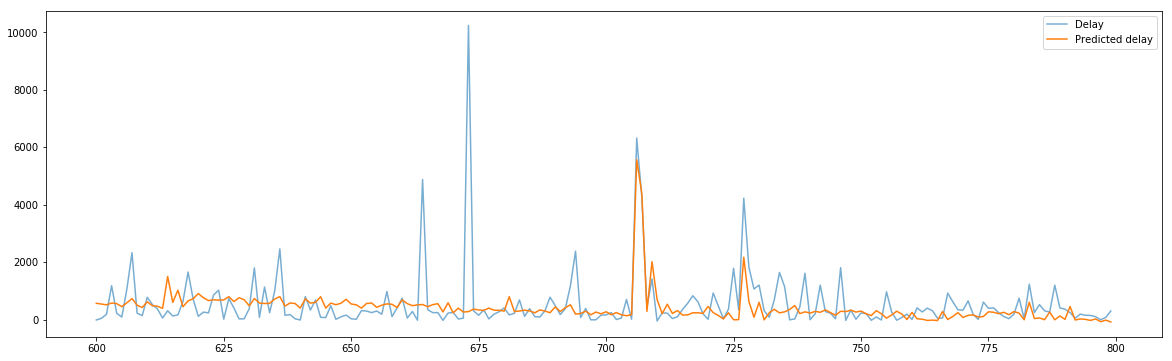

In [8]:
# A piece of data...
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.plot(results.index.values[600:800], results['ACTUAL'][600:800], label="Delay", alpha=0.6)
plt.plot(results.index.values[600:800], results['Delay'][600:800], label="Predicted delay", alpha=1)
plt.legend()
plt.show()

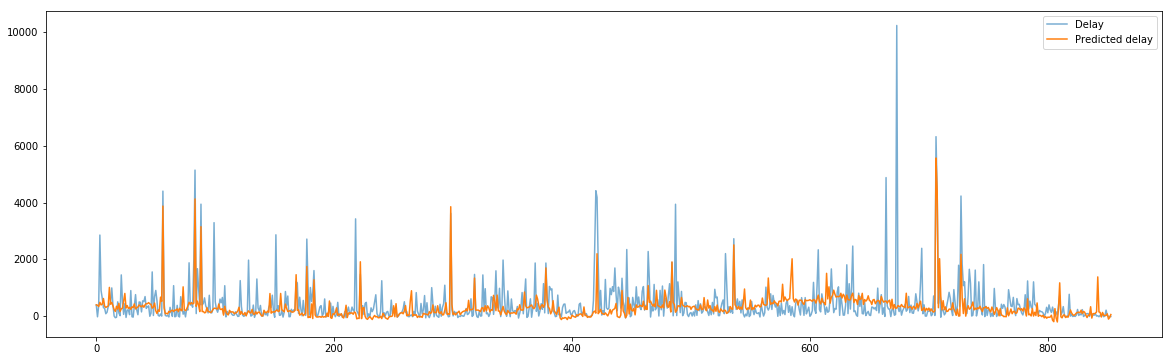

In [9]:
# All the data...
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.plot(results.index.values, results['ACTUAL'], label="Delay", alpha=0.6)
plt.plot(results.index.values, results['Delay'], label="Predicted delay", alpha=1)
plt.legend()
plt.show()

 > There are some big delays, that could not be predicted, like index 674, but those that could be predicted
 were already late at departure:

In [10]:
results.loc[results['ACTUAL'] > 5000]

,ACTUAL,Delay,Delay at Dep.,12h Coldest Arrival,12h Rain max Arrival,12h Rain total Arrival,12h Snow depth Arrival,12h Coldest Dep,12h Rain max Dep,12h Rain total Dep,12h Snow depth Dep
83,5145,4127.537005,4314.0,0.8,3.5,21.4,4.0,-2.5,3.5,36.6,28.0
673,10244,283.381870,-11.0,-7.5,0.0,0.0,21.0,-17.0,0.0,0.0,57.0
706,6324,5572.146754,6360.0,0.4,0.0,0.0,24.0,-2.4,0.0,0.0,62.0



> Now, if we try to predict delays without the knowledge of late departures, the results are quite bad:

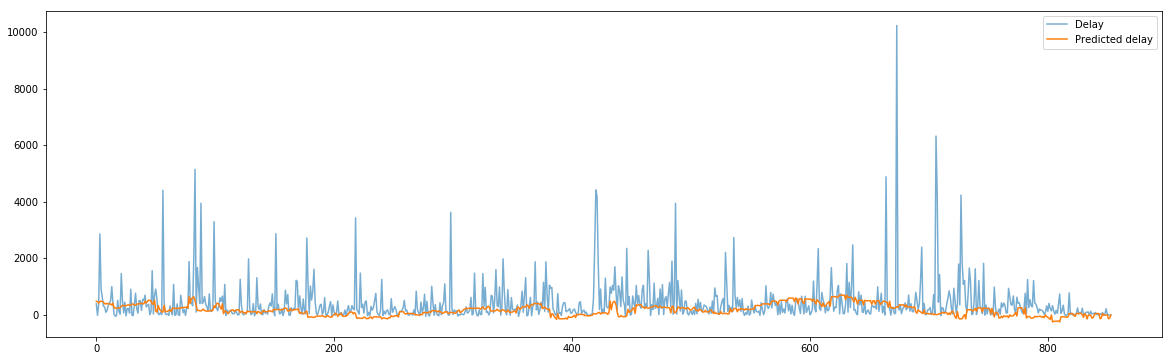

Algorithm score: 0.064330


In [11]:
# Let's try again with "Delay at Dep." dropped:
training3 = training.loc[:, training.columns != 'Delay at Dep.'].copy()
scaler3 = MinMaxScaler(feature_range=(-1, 1))
scaler3 = scaler3.fit(training3)
colnames2 = training3.columns

X2 = X.loc[:, X.columns != 'Delay at Dep.'].copy()

testdata2 = testing.loc[:, (testing.columns != 'Delay at Dep.')]
testdata2 = pd.DataFrame(scaler3.transform(testdata2), columns=colnames2)
testdata2 = testdata2.loc[:, testdata2.columns != 'Delay']

max_iter = 200
layers = (5)
alphas = 0.1
init = 0.1

# alusta mlp 
mlp = MLPRegressor(verbose=0, random_state=0, max_iter=max_iter, batch_size='auto', activation='identity',
                  learning_rate_init=init, solver='lbfgs', alpha=alphas, hidden_layer_sizes=layers )
mlp.fit(X2, y)
result = mlp.predict(testdata2)

results2 = testdata2.copy()
results2.insert(0, 'preds', result)#
results2 = pd.DataFrame(scaler3.inverse_transform(results2), columns=colnames2)
results2.insert(0, 'ACTUAL', testing['Delay'])#

# Visualize the data...
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.plot(results2.index.values, results2['ACTUAL'], label="Delay", alpha=0.6)
plt.plot(results2.index.values, results2['Delay'], label="Predicted delay", alpha=1)
plt.legend()
plt.show()
print("Algorithm score: %f" % mlp.score(X2, y))

---
## K Nearest Neighbour Regressor

Predicting with KNN

Training set score: 0.999923


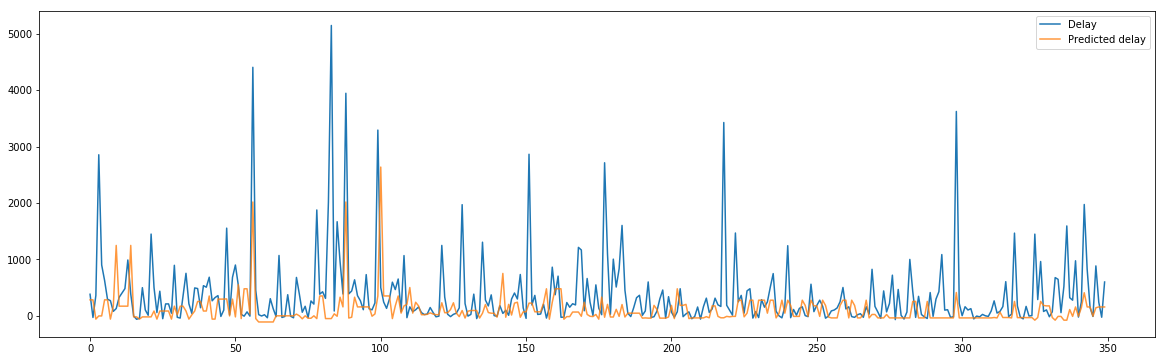

In [12]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=1, weights='uniform', algorithm='auto', p=2) #'auto','ball_tree','kd_tree','brute'
neigh.fit(X, y) # use the same data as before

result = neigh.predict(testdata) # prediction with knn
 
results = testdata.copy()
results.insert(0, 'preds', result)#
results = pd.DataFrame(scaler.inverse_transform(results), columns=colnames)

# Print score and loss
print("Training set score: %f" % neigh.score(X, y))
#print(results.iloc[0])
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
plt.plot(testing.index.values[0:350], testing['Delay'][0:350], label="Delay", alpha=1)
plt.plot(results.index.values[0:350], results['Delay'][0:350], label="Predicted delay", alpha=0.8)
plt.legend()
plt.show()


---

## Classification. Try to predict, if a train is late or not

Predicting punctuality with a few algorithms. KNN seems to be working most accurately in this case. Naive Bayes is just being pessimistic: nearly all trains are late...


In [125]:
# We use the same scaled 'X' -dataframe than before, but
# for classification, we convert 'Delay' to 1's and 0's. Late = 1, Early = 0

def io(row):
    if row > 0:
        return 1
    else:
        return 0

# Select training data (convert one-hot)
training['Delay'] = training['Delay'].apply(io)

# Set target column
y = training['Delay']

# Convert test data's 'Delay' to 0 and 1
testing['Delay'] = testing['Delay'].apply(io)


### K Nearest Neighbour (KNN) Classifier

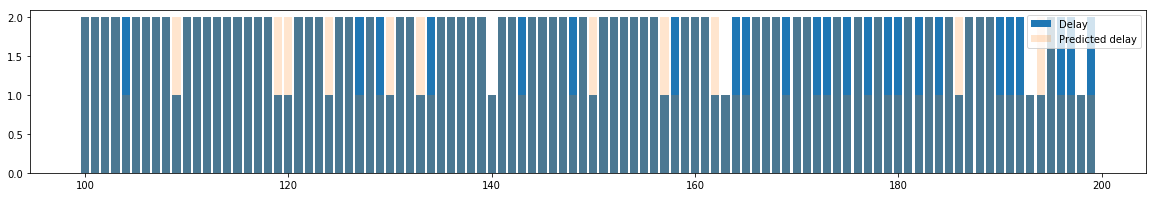

Accuracy:  580 / 854 = 0.6791569086651054 
Trains delayed   :  737 
Predicted delayed:  617


In [126]:
# loading library
from sklearn.neighbors import KNeighborsClassifier

# Learning model
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')

# Fit he model
knn.fit(X, y)

# Predict schedule
prediction = pd.DataFrame(knn.predict(testdata))

# Visualize
fig, ax = plt.subplots()
fig.set_size_inches(20, 3)
#plt.style.use('seaborn-notebook') # apply style
plt.bar(testing.index.values[100:200], testing['Delay'][100:200]+1, label="Delay", alpha=1)
plt.bar(prediction.index.values[100:200], prediction[0][100:200]+1, label="Predicted delay", alpha=0.2)
plt.legend()
plt.show()

# Let's count the accuracy
correct = 0
count_ones = 0
for index, row in testing.iterrows():
    count_ones += row['Delay']
    if row['Delay'] == prediction[0][index]:
        correct += 1

print("Accuracy: ", correct, "/",len(testing), "=", correct/len(testing),"\nTrains delayed   : ", 
      np.int64(count_ones), "\nPredicted delayed: ", prediction[0].value_counts()[1])

### Random forest classifier

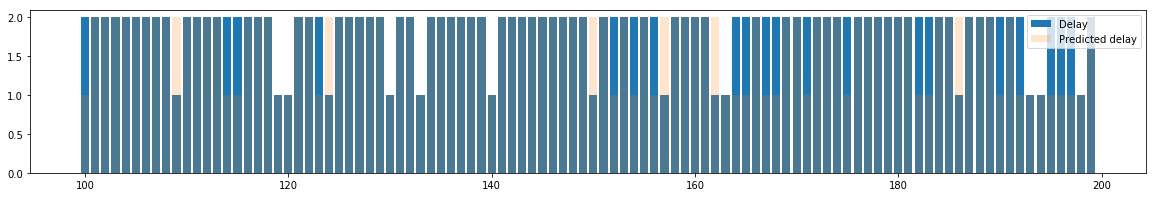

Accuracy:  575 / 854 = 0.6733021077283372 
Trains delayed   :  737 
Predicted delayed:  586


In [127]:
from sklearn.ensemble import RandomForestClassifier

# Select data (convert one-hot)
testing['Delay'] = testing['Delay'].apply(io)
training['Delay'] = training['Delay'].apply(io)
y = training['Delay']
X = training.loc[:, training.columns != 'Delay']


clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X, y)

testdata2 = testing.loc[:, testing.columns != 'Delay']
prediction = pd.DataFrame(clf.predict(testdata2))

# Visualize
fig, ax = plt.subplots()
fig.set_size_inches(20, 3)
plt.bar(testing.index.values[100:200], testing['Delay'][100:200]+1, label="Delay", alpha=1)
plt.bar(prediction.index.values[100:200], prediction[0][100:200]+1, label="Predicted delay", alpha=0.2)
plt.legend()
plt.show()

# Let's count the accuracy
correct = 0
count_ones = 0
for index, row in testing.iterrows():
    count_ones += row['Delay']
    if row['Delay'] == prediction[0][index]:
        correct += 1

print("Accuracy: ", correct, "/",len(testing), "=", correct/len(testing),"\nTrains delayed   : ", 
      np.int64(count_ones), "\nPredicted delayed: ", prediction[0].value_counts()[1])

### Naive Bayes classification

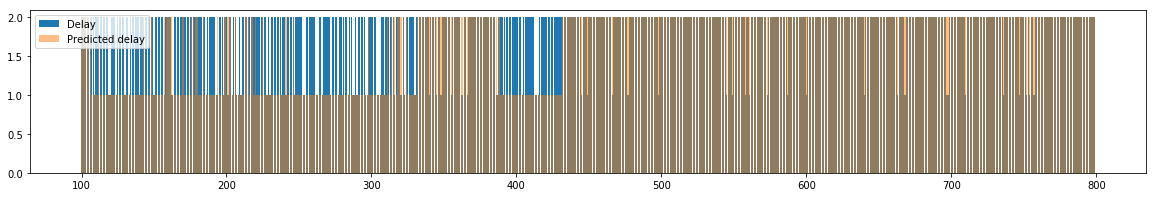

Accuracy:  542 / 854 = 0.6346604215456675 
Trains delayed   :  737 
Predicted delayed:  531


In [128]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
gnb = BernoulliNB()

y = training['Delay']
X = training.loc[:, training.columns != 'Delay']

gnb.fit(X,y)

ypred = pd.DataFrame(gnb.predict(testdata))

# Visualize
fig, ax = plt.subplots()
fig.set_size_inches(20, 3)
plt.bar(testing.index.values[100:800], testing['Delay'][100:800]+1, label="Delay", alpha=1)
plt.bar(ypred.index.values[100:800], ypred[0][100:800]+1, label="Predicted delay", alpha=0.5)
plt.legend()
plt.show()

# Let's count the accuracy
correct = 0
count_ones = 0
for index, row in testing.iterrows():
    count_ones += row['Delay']
    if row['Delay'] == ypred[0][index]:
        correct += 1

print("Accuracy: ", correct, "/",len(testing), "=", correct/len(testing),"\nTrains delayed   : ", 
      np.int64(count_ones), "\nPredicted delayed: ", ypred[0].value_counts()[1])